# Logistic growth models of SARS-CoV-2 strain ratios

This notebook explores multivariate logistic growth models, with applications to determining the relative proportions of SARS-CoV-2 strains over time.

#### Table of contents

* [Overview](#Overview)
* [Loading data](#Loading-data)
* [A First Model](#A-first-model)
* [Defining a regional model](#Defining-a-regional-model)
* [Defining an alternative regional model](#Defining-an-alternative-regional-model)

## Overview <a name="Overview" />

In [1]:
import os
from functools import partial

import numpy as np
import torch

import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("Using GPU")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    print("Using CPU")
    
smoke_test = ('CI' in os.environ)

Using CPU


## Loading data <a name="Loading-data" />

Our data inputs consist of a few million genetically sampled SARS-CoV-2 viruses, clustered into [PANGO lineages](https://cov-lineages.org), and aggregated into a few hundred regions globally and into 28-day time bins. Preprocessing was performed by Nextstrain's [ncov](https://docs.nextstrain.org/projects/ncov/en/latest/reference/remote_inputs.html) tool, and aggregation was performed by the Broad Institute's [pyro-cov](https://github.com/broadinstitute/pyro-cov/blob/master/scripts/preprocess_nextstrain.py) tool.

In [2]:
from pyro.contrib.examples.nextstrain import load_nextstrain_counts
dataset = load_nextstrain_counts()

def summarize(x, name=""):
    if isinstance(x, dict):
        for k, v in sorted(x.items()):
            summarize(v, name + "." + k if name else k)
    elif isinstance(x, torch.Tensor):
        print(f"{name}: {type(x).__name__} of shape {tuple(x.shape)} on {x.device}")
    elif isinstance(x, list):
        print(f"{name}: {type(x).__name__} of length {len(x)}")
    else:
        print(f"{name}: {type(x).__name__}")
summarize(dataset)

counts: Tensor of shape (27, 202, 1316) on cpu
features: Tensor of shape (1316, 2634) on cpu
lineages: list of length 1316
locations: list of length 202
mutations: list of length 2634
sparse_counts.index: Tensor of shape (3, 57129) on cpu
sparse_counts.total: Tensor of shape (27, 202) on cpu
sparse_counts.value: Tensor of shape (57129,) on cpu
start_date: datetime
time_step_days: int


The main two pieces of data are a counts tensor and a feature matrix. The `dataset["counts"]` tensor has shape (T,P,S) where `T` is the number of time bins, `P` is the number of places or locations, and `S` is the number of strains or PANGO lineages, and `dataset["counts"][t,p,s]` is the number of samples in that time-place-strain bin. The `dataset["features"]` matrix has shape (S,M) where `S` is the number of strains or PANGO lineages, and `M` is the number of mutations we consider, and `dataset["features"][s,m]` is the portion of samples classified as lineage `s` that exhibit mutation `m` (note this is not quite binary, because each lineage is heterogeneous).

The count data is heavily skewed towards a few large regions and dominant lineages like `B.1.1.7` and `B.1.617.2`.

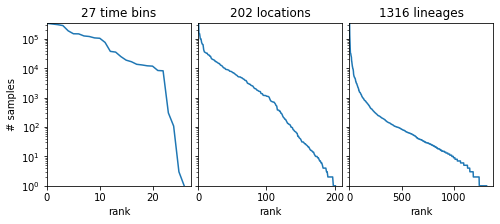

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
for i, name in enumerate(["time bin", "location", "lineage"]):
    counts = dataset["counts"].sum(list({0, 1, 2} - {i}))
    Y = counts.sort(0, True).values
    axes[i].plot(Y)
    axes[i].set_xlim(0, None)
    axes[0].set_ylim(1, None)
    axes[i].set_yscale("log")
    axes[i].set_xlabel(f"rank")
    axes[i].set_title(f"{len(Y)} {name}s")
axes[0].set_ylabel("# samples")
plt.subplots_adjust(wspace=0.05);

## Helpers for manipulating data

In [4]:
def get_lineage_id(s):
    """Get lineage id from string name"""
    return np.argmax(np.array([s]) == dataset['lineages'])

def get_location_id(s):
    """Get location id from string name"""
    return np.argmax(np.array([s]) == dataset['locations'])

def get_aggregated_counts_from_locations(locations):
    """Get aggregated counts from a list of locations"""
    return sum([dataset['counts'][:, get_location_id(loc)] for loc in locations])

## A first model

First let's zoom-in on Massachusetts and a few surrounding states and the alpha and delta lineages: 

In [5]:
northeast_states = ['USA / New York', 
                    'USA / Massachusetts', 
                    'USA / Connecticut', 
                    'USA / New Hampshire',
                    'USA / Vermont',
                    'USA / New Jersey',
                    'USA / Maine',
                    'USA / Rhode Island', 
                    'USA / Pennsylvania']

northeast_counts = get_aggregated_counts_from_locations(northeast_states)
alpha_counts = northeast_counts[:, get_lineage_id('B.1.1.7')]
delta_counts = northeast_counts[:, get_lineage_id('B.1.617.2')]

# let's combine the counts into a single tensor
alpha_delta_counts = torch.stack([alpha_counts, delta_counts]).T
print(alpha_delta_counts.shape)

torch.Size([27, 2])


Let's plot the raw time series of counts for both lineages:

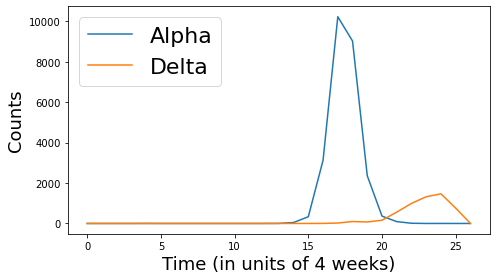

In [6]:
plt.figure(figsize=(7, 4))
plt.plot(np.arange(alpha_counts.shape[0]), alpha_counts, label='Alpha')
plt.plot(np.arange(delta_counts.shape[0]), delta_counts, label='Delta')
plt.xlabel("Time (in units of 4 weeks)", fontsize=18)
plt.ylabel("Counts", fontsize=18)
plt.legend(fontsize=22)
plt.tight_layout()

We see that at first Alpha was dominant, but then Delta started outcompeting it until Delta became dominant.

### Model definition

In [7]:
def basic_model(counts):
    T, L = counts.shape

    # Define plates over lineage and time
    lineage_plate = pyro.plate("lineages", L, dim=-1)
    time_plate = pyro.plate("time", T, dim=-2)

    # Define a rate and intercept for each lineage
    with lineage_plate:
        rate = pyro.sample("rate", dist.Normal(0, 1))
        init = pyro.sample("init", dist.Normal(0, 1))

    # We measure time in units of the SARS-CoV-2 generation time of 5.5 days
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5
    
    # Assume lineages grow linearly in logit space
    logits = init + rate * time[:, None]
    probs = torch.softmax(logits, dim=-1)
    assert probs.shape == (T, L)
    
    # Observe counts via a multinomial likelihood.
    with time_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(probs=probs.unsqueeze(-2), validate_args=False),
            obs=counts.unsqueeze(-2),
        )

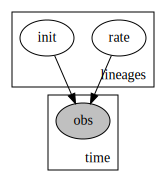

In [8]:
# Let's look at graphical structure of our model
pyro.render_model(partial(basic_model, alpha_delta_counts))

### Define helper for fitting models

In [9]:
def fit_svi(model, lr=0.1, num_steps=1001, log_every=250):
    pyro.clear_param_store()
    pyro.set_rng_seed(20211206)
    if smoke_test:
        num_steps = 2
        
    # Train via mean field variational inference.
    guide = AutoNormal(model, init_scale=0.01)
    optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1 / num_steps)})
    svi = SVI(model, guide, optim, Trace_ELBO())
    losses = []
    for step in range(num_steps):
        loss = svi.step()
        losses.append(loss)
        if step % log_every == 0:
            print(f"step {step: >4d} loss = {loss:0.6g}")
            
    # Plot to assess convergence.
    plt.figure(figsize=(6, 3))
    plt.plot(losses)
    plt.xlabel("SVI step", fontsize=18)
    plt.ylabel("loss", fontsize=18)
    plt.tight_layout()

    return guide

### Let's fit `basic_model` and inspect the results

step    0 loss = 18900.4
step  250 loss = 224.146
step  500 loss = 194.991
step  750 loss = 159.859
step 1000 loss = 132.551
step 1250 loss = 238.929
step 1500 loss = 147.259


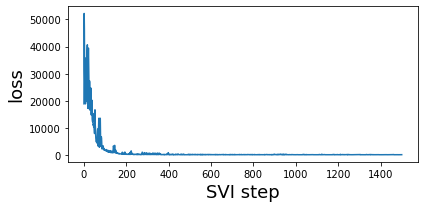

In [10]:
# We truncate the data to the period with non-zero counts
guide = fit_svi(partial(basic_model, alpha_delta_counts[14:]), num_steps=1501)

### Let's inspect the posterior means of our latent parameters

In [11]:
for k, v in guide.median().items():
    print(k, v.data.cpu().numpy())

rate [-0.20363875  0.20364828]
init [ 6.7013316 -6.7033477]


As expected the Delta lineage has a differential growth rate advantage with respect to the Alpha lineage:

In [12]:
print("multiplicative advantage: {:.2f}".format(
      np.exp(guide.median()['rate'][1] - guide.median()['rate'][0])))

multiplicative advantage: 1.50


This seems like an overestimate. Can we get better estimates by modeling each spatial region individually?

## Defining a regional model

In [13]:
# first extract the data we want to use
alpha_id = get_lineage_id('B.1.1.7')
delta_id = get_lineage_id('B.1.617.2')
counts = dataset['counts'][:, :, [alpha_id, delta_id]]

In [14]:
# Model each region as multivariate logistic growth.
def regional_model(counts):
    T, R, L = counts.shape
        
    # Now we also define a region plate
    lineage_plate = pyro.plate("lineages", L, dim=-1)
    region_plate = pyro.plate("region", R, dim=-2)
    time_plate = pyro.plate("time", T, dim=-3)

    # We use the same growth rate (slope) for each region
    with lineage_plate:
        rate = pyro.sample("rate", dist.Normal(0, 1))
        
    # We allow the the init to vary from region to region
    init_scale = pyro.sample("init_scale", dist.LogNormal(0, 2))
    with region_plate, lineage_plate:
        init = pyro.sample("init", dist.Normal(0, init_scale))

    # We measure time in units of the SARS-CoV-2 generation time of 5.5 days
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5

    logits = init + rate * time[:, None, None]
    
    # Observe sequences via a multinomial likelihood.
    with time_plate, region_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(logits=logits.unsqueeze(-2), validate_args=False),
            obs=counts.unsqueeze(-2),
        )

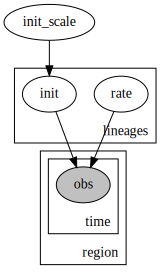

In [15]:
# Let's look at the graphical structure of our model
pyro.render_model(partial(regional_model, counts))

step    0 loss = 481989
step  250 loss = 244822
step  500 loss = 122902
step  750 loss = 97737.9
step 1000 loss = 95103.5
step 1250 loss = 73333.3
step 1500 loss = 52314.7
step 1750 loss = 55758.5
step 2000 loss = 40749.7
step 2250 loss = 39190
step 2500 loss = 38332.9
step 2750 loss = 26367.2
step 3000 loss = 24913


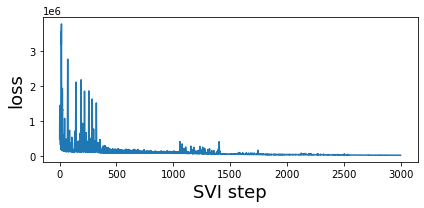

In [16]:
guide = fit_svi(partial(regional_model, counts), num_steps=3001)

In [17]:
print("multiplicative advantage: {:.2f}".format(
      np.exp(guide.median()['rate'][1] - guide.median()['rate'][0])))

multiplicative advantage: 1.16


## Defining an alternative regional model

The regional model we defined above assumed that the `rate` for each lineage did not vary between regions. Here we add additional hierarchical structure and allow the rate to vary from region to region.

In [18]:
def regional_model2(counts):
    T, R, L = counts.shape
    
    lineage_plate = pyro.plate("lineages", L, dim=-1)
    region_plate = pyro.plate("region", R, dim=-2)
    time_plate = pyro.plate("time", T, dim=-3)

    # We assume the init can vary a lot from region to region but
    # that the rate varies considerably less.
    init_scale = pyro.sample("init_scale", dist.LogNormal(0, 2))
    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4, 2))
    
    # the per-region per-lineage rate is governed by a hierarchical prior
    with lineage_plate:
        rate_lineage = pyro.sample("rate", dist.Normal(0, 1))
        
    # We allow the rate and init to vary from region to region
    with region_plate, lineage_plate:
        rate_region_lineage = pyro.sample("rate_region_lineage", 
                                          dist.Normal(rate_lineage, rate_scale))
        init = pyro.sample("init", dist.Normal(0, init_scale))

    # We measure time in units of the SARS-CoV-2 generation time of 5.5 days
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5

    logits = init + rate_region_lineage * time[:, None, None]
    
    # Observe sequences via a multinomial likelihood.
    with time_plate, region_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(logits=logits.unsqueeze(-2), validate_args=False),
            obs=counts.unsqueeze(-2),
        )

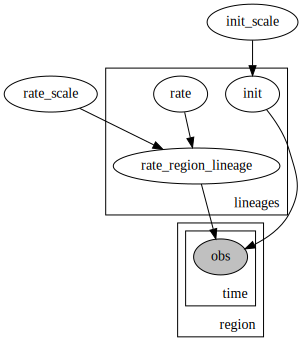

In [19]:
# Let's look at the graphical structure of our model
pyro.render_model(partial(regional_model2, counts))

step    0 loss = 397076
step  250 loss = 176604
step  500 loss = 165475
step  750 loss = 124165
step 1000 loss = 98706.2
step 1250 loss = 72609.7
step 1500 loss = 60591.5
step 1750 loss = 55031.9
step 2000 loss = 47228.6
step 2250 loss = 38411.4
step 2500 loss = 34806.3
step 2750 loss = 30635.8
step 3000 loss = 26564.1


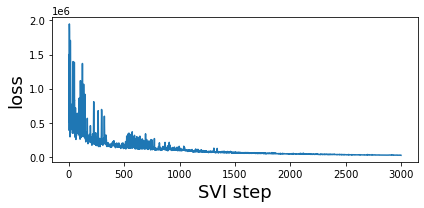

In [20]:
guide = fit_svi(partial(regional_model2, counts), num_steps=3001)

In [21]:
print("multiplicative advantage: {:.2f}".format(
      np.exp(guide.median()['rate'][1] - guide.median()['rate'][0])))

multiplicative advantage: 1.16
